In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets

import utils as my_utils
from model import Net, Net2

# Loading the `data set`

In [2]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=my_utils.train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=my_utils.test_transforms)

In [3]:
batch_size = 512

kwargs = {'batch_size': batch_size, 
          'shuffle': True, 
          'num_workers': 2, 
          'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs) 

# EDA

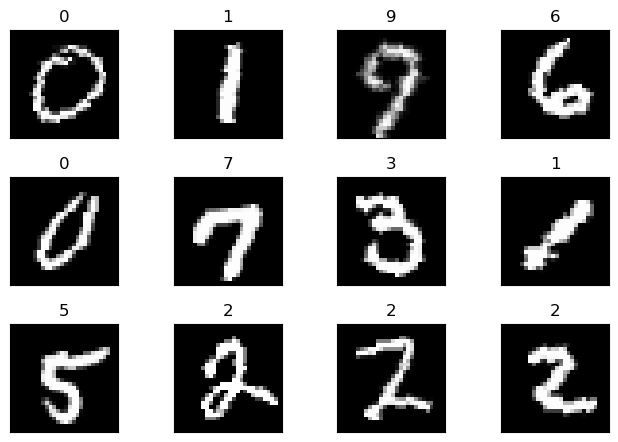

In [4]:
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [5]:
len(batch_label)

512

In [6]:
batch_data[i][0].shape

torch.Size([28, 28])

# Visualizing the `network`

In [9]:
# !pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [10]:
from torchsummary import summary

device = my_utils.device
model = Net().to(device)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [11]:
from torchsummary import summary

device = my_utils.device
model2 = Net2().to(device)

summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------


# Training the `model` 

In [18]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [19]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
    
    model.train()
    pbar = tqdm(train_loader)
    
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # Predict
        pred = model(data)
        
        # Calculate loss
        loss = criterion(pred, target)
        train_loss+=loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        correct += GetCorrectPredCount(pred, target)
        processed += len(data)
        
        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

    
def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    

In [20]:
lr = 0.01
momentum = 0.9 
step_size = 15
gamma=0.1
num_epochs = 20

model = Net().to(device)
optimizer = my_utils.optimizer_fn(model, lr=lr, momentum=momentum)
scheduler = my_utils.scheduler_fn(optimizer, step_size, gamma)
criterion = my_utils.criterion


for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3808 Batch_id=117 Accuracy=51.27: 100%|██████████| 118/118 [00:12<00:00,  9.08it/s]


Test set: Average loss: 0.0004, Accuracy: 9352/10000 (93.52%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1395 Batch_id=117 Accuracy=94.14: 100%|██████████| 118/118 [00:13<00:00,  9.06it/s]


Test set: Average loss: 0.0002, Accuracy: 9743/10000 (97.43%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0525 Batch_id=117 Accuracy=96.36: 100%|██████████| 118/118 [00:12<00:00,  9.10it/s]


Test set: Average loss: 0.0001, Accuracy: 9796/10000 (97.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1646 Batch_id=117 Accuracy=97.11: 100%|██████████| 118/118 [00:12<00:00,  9.09it/s]


Test set: Average loss: 0.0001, Accuracy: 9853/10000 (98.53%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0509 Batch_id=117 Accuracy=97.60: 100%|██████████| 118/118 [00:13<00:00,  9.08it/s]


Test set: Average loss: 0.0001, Accuracy: 9855/10000 (98.55%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0174 Batch_id=117 Accuracy=97.85: 100%|██████████| 118/118 [00:12<00:00,  9.09it/s]


Test set: Average loss: 0.0001, Accuracy: 9878/10000 (98.78%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0437 Batch_id=117 Accuracy=98.03: 100%|██████████| 118/118 [00:12<00:00,  9.09it/s]


Test set: Average loss: 0.0001, Accuracy: 9866/10000 (98.66%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0972 Batch_id=117 Accuracy=98.22: 100%|██████████| 118/118 [00:13<00:00,  9.08it/s]


Test set: Average loss: 0.0001, Accuracy: 9854/10000 (98.54%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0404 Batch_id=117 Accuracy=98.45: 100%|██████████| 118/118 [00:13<00:00,  9.01it/s]


Test set: Average loss: 0.0001, Accuracy: 9893/10000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0397 Batch_id=117 Accuracy=98.39: 100%|██████████| 118/118 [00:12<00:00,  9.08it/s]


Test set: Average loss: 0.0001, Accuracy: 9892/10000 (98.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0695 Batch_id=117 Accuracy=98.58: 100%|██████████| 118/118 [00:13<00:00,  9.07it/s]


Test set: Average loss: 0.0001, Accuracy: 9893/10000 (98.93%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0039 Batch_id=117 Accuracy=98.76: 100%|██████████| 118/118 [00:12<00:00,  9.09it/s]


Test set: Average loss: 0.0001, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0200 Batch_id=117 Accuracy=98.81: 100%|██████████| 118/118 [00:12<00:00,  9.09it/s]


Test set: Average loss: 0.0001, Accuracy: 9905/10000 (99.05%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0055 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:13<00:00,  9.03it/s]


Test set: Average loss: 0.0001, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0466 Batch_id=117 Accuracy=98.89: 100%|██████████| 118/118 [00:12<00:00,  9.08it/s]


Test set: Average loss: 0.0001, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0542 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:13<00:00,  9.05it/s]


Test set: Average loss: 0.0000, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0162 Batch_id=117 Accuracy=99.19: 100%|██████████| 118/118 [00:13<00:00,  9.07it/s]


Test set: Average loss: 0.0000, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0256 Batch_id=117 Accuracy=99.16: 100%|██████████| 118/118 [00:13<00:00,  9.05it/s]


Test set: Average loss: 0.0000, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0316 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:12<00:00,  9.08it/s]


Test set: Average loss: 0.0000, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0042 Batch_id=117 Accuracy=99.19: 100%|██████████| 118/118 [00:13<00:00,  9.06it/s]


Test set: Average loss: 0.0000, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-03.


## Visualization of `Training` and `Test` Metrics

Text(0.5, 1.0, 'Test Accuracy')

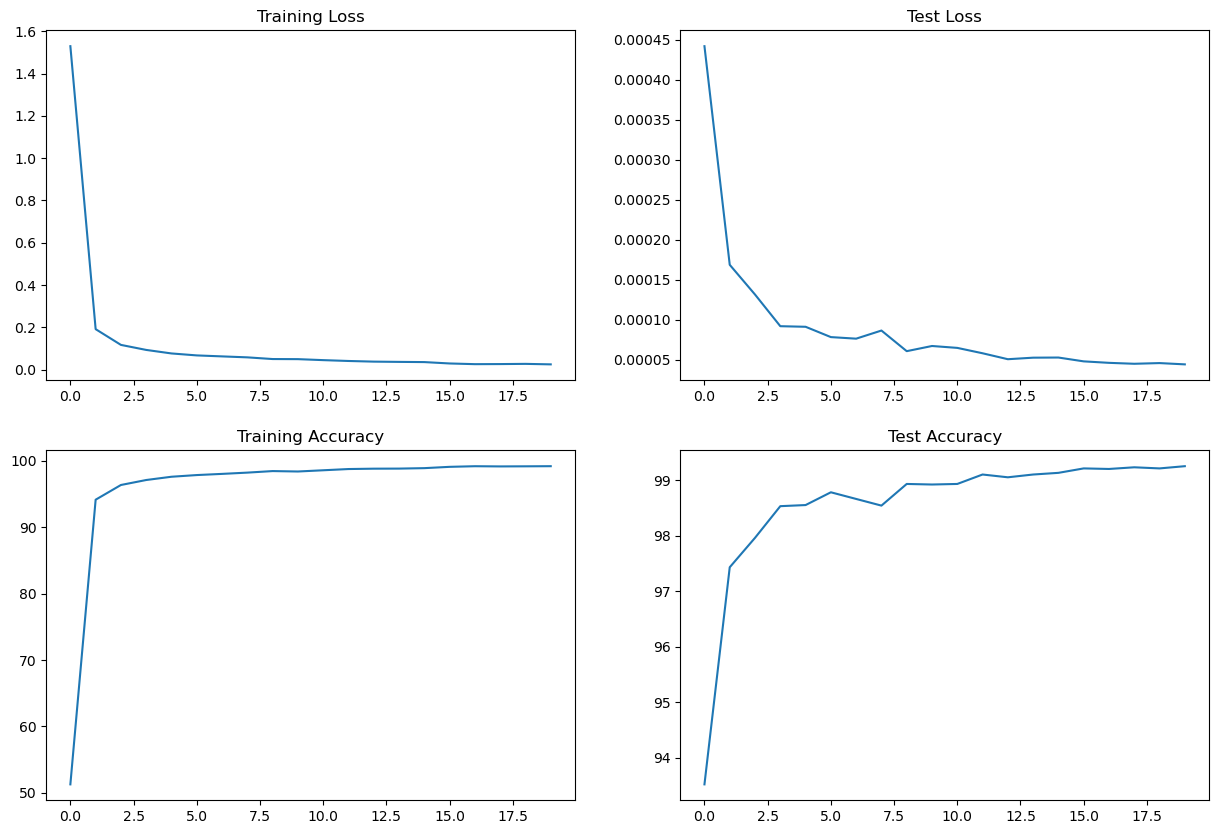

In [21]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")